# Project

In [1]:
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_ext_filter
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
speed_r = 100
speed_f = 100
stop = 0
MIN_DIST = 40
ANGLE_TOLERANCE = 0.30
PERIOD = 0.001
SPEED_AVG = 200
ROBOT_SPEED_TO_MM = 100/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(goal_dist, angle):
    kp_rot = 100
    kp_lin = 3

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = 80 - kp_rot*(angle)
        speed_r = 80 + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG
        speed_r = SPEED_AVG
    return speed_l, speed_r

In [4]:
def pathing (video_capture, filter, path, x0, y0, theta0, periode=0.01):
    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[0][0]
    goaly = path[0][1]
    
    i = 0
    x_pense = x0
    y_pense = y0
    curr_time = 0
    
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    
                    position_measure = invert_coordinates(position_measure)
                    position_measure[0:2] = pixel_to_metric(position_measure[0:2])

                    [kx, ky, kteta] = [position_measure[0], position_measure[1], -theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        [pred_x, pred_y, pred_teta], _, curr_time = filter.filter(measurement, curr_time) 
        
        dist = distance (goalx, goaly, pred_x, pred_y)
        teta[i] = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                x_pense = path[i-1][0]
                y_pense = path[i-1][1]
                vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                vec2 = [goalx - x_pense, goaly - y_pense]
                angle = get_angle_between(vec1, vec2)
            else:
                motors(stop, stop)
                break
        else :
            x_pense = pred_x + speed_f * periode * np.cos(teta[i]) #à update
            y_pense = pred_y + speed_f * periode * np.sin(teta[i])
            angle =  wrap_angle((teta[i] - pred_teta) % (2*np.pi))
            
            speed_l, speed_r = controller(dist, angle)
            #speed_l  = SPEED_AVG
            #speed_r = SPEED_AVG
        
        # set input for kalman filter
        filter.u = np.array([speed_l, speed_r]) * ROBOT_SPEED_TO_MM

        motors(int(speed_l),int(speed_r))

        controller(dist,angle)
        #print(i, camera_available, dist, position_measure, angle, teta[i], kteta)
        
        #print("camera : %.3f %.3f %.4f" %(kx, ky, kteta))
        #print("kalman : %.3f %.3f %.4f" %(pred_x, pred_y, pred_teta))
        print("error : %.3f %.3f %.4f" %(kx-pred_x, ky-pred_y, kteta-pred_teta))
        #cv2.imshow("frame", cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    motors(stop, stop)

# Main 

1
2
3
start = [812.025 394.2  ] goal = [764.775 507.6  ]


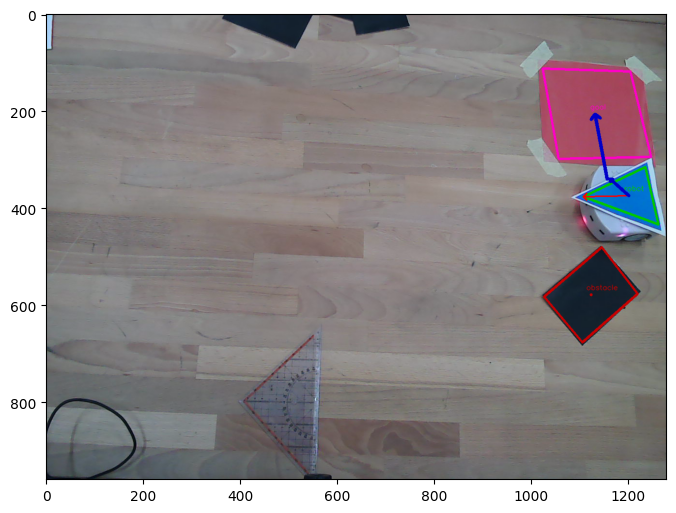

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
fig, ax = plt.subplots(figsize=(8,8))
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-7)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)
    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    filter = kalman_ext_filter(metric_start[0], metric_start[1], -robot[2], 0, 0 ,SPEED_AVG, PERIOD)
    print('start =', metric_start, 'goal =', metric_goal)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)
#
motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

4


In [7]:
pathing(video_capture, filter, metric_path, metric_start[0], metric_start[1], -robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)

error : -0.000 0.000 -0.0000
error : -0.000 0.000 -0.0000
error : 0.001 -0.450 -0.0072
error : 0.001 -0.337 0.0107
error : 11.488 -0.026 -0.0086
error : 20.677 0.203 -0.0072
error : 21.735 0.395 0.0123
error : 18.631 -0.015 0.0198
error : 16.877 -0.377 -0.0013
error : 14.576 -0.093 0.0082
error : 13.370 -0.448 0.0075
error : 8.907 -0.140 0.0159
error : 4.017 0.166 0.0144
error : 1.347 0.464 0.0039
error : -1.175 0.126 -0.0059
error : -0.532 0.440 -0.0056
error : -1.068 0.740 -0.0053
error : -2.488 0.396 -0.0051
error : -2.543 0.712 -0.0048
error : -1.058 1.005 -0.0046
error : -1.467 1.289 -0.0044
error : -0.758 1.560 -0.0042
error : -3.789 1.839 -0.0136
error : -6.586 2.126 5.9989
error : -10.226 2.427 -0.2634
error : -11.957 3.379 -0.2533
error : -9.191 3.635 -0.2439
error : -11.183 4.550 5.8143
error : -9.124 5.427 5.6046
error : -9.610 5.632 5.4271
error : -7.940 5.827 5.2430
error : -6.175 6.665 5.0883
error : -5.866 7.482 4.9250
error : -5.637 8.281 4.7803
error : -6.995 9.072 4.6

KeyboardInterrupt: 